In [ ]:
!nvidia-smi #查看GPU型号

### 下载 Whisper 并克隆项目

In [ ]:
#避免Colab断开连接的方法：
#在网页内按键Ctrl+Shift+I，跳到控制台界面，输入以下的内容：
#function ConnectButton(){
    #console.log("Connect pushed"); 
    #document.querySelector("#top-toolbar > colab-connect-button").shadowRoot.querySelector("#connect").click()}
#setInterval(ConnectButton,60000);
#记得删掉前面的#

In [ ]:
!git clone https://github.com/zwa73/whisper-vits-japanese-Fork.git
!mv whisper-vits-japanese-Fork whisper-vits-japanese

In [ ]:
%%capture
!pip install git+https://github.com/openai/whisper.git

In [ ]:
!cp -r /content/whisper-vits-japanese/whisper/transcribe.py /usr/local/lib/python3.8/dist-packages/whisper
!cp -r /content/whisper-vits-japanese/whisper/utils.py /usr/local/lib/python3.8/dist-packages/whisper

In [ ]:
import whisper

### 链接谷歌网盘
### Prepare Data for Whisper ASR

In [ ]:
# @markdown <br/>链接谷歌网盘
from google.colab import drive
drive.mount('/content/drive')

###此处是唯一需要自己改动的地方：自己的音频zip路径

In [ ]:
#目前支持日语，换成别语言需替换text文件夹cleaner和symbols以及config文件夹中isla_base.json的cleaner参数
#这里只需用新路径替换掉/content/drive/MyDrive/isla_base/isla.zip即可(音频需为wav)
#!unzip -j /content/drive/MyDrive/isla_base/isla.zip "*/*.wav" -d /content/whisper-vits-japanese/audio

In [ ]:
#如果没有训练数据只想体验的话，这里只能暂时借用下White老师的数据集了，作为入门材料真是万分感谢
#%cd /content/whisper-vits-japanese
#!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1H6aqdGP-h-MT7XAVk870Ql4d3QrJT-7o' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1H6aqdGP-h-MT7XAVk870Ql4d3QrJT-7o" -O "isla.zip" && rm -rf /tmp/cookies.txt
#!unzip -j /content/whisper-vits-japanese/isla.zip "*/*.wav" -d /content/whisper-vits-japanese/audio

In [ ]:
# @markdown <br/>运行Whisper识别音频
# @markdown <br/>识别过程总共花费50分钟(大概是音频总长的三分之一到一半左右)
# @markdown <br/>模型大小
model_type = "large" # @param ["small", "medium", "large"]
!whisper -i /content/whisper-vits-japanese/audio -o /content/whisper-vits-japanese/srt_files --language Japanese --model {model_type}

In [ ]:

# @markdown <br/>auto.py会根据Whisper导出的srt自动切片音频、转写文本、转采样率为22050HZ
# @markdown <br/>最后会把适配VIST的数据格式汇总在/content/whisper-vits-japanese/filelists
# @markdown <br/>然后音频数据会被放在/content/whisper-vits-japanese/sliced_audio文件夹里

# @markdown <br/>你所要使用的音频采样率。
sampling_rate = 44100 # @param {type:"number"}

# @markdown <br/>单人训练集格式 path/to/XXX.wav|transcript
# @markdown <br/>多人训练集格式 path/to/XXX.wav|speaker id|transcript
# @markdown <br/>默认为单人，VCTK需将格式改为 dataset/001.wav|0|こんにちは。
# @markdown <br/>过小的训练集可能会导致Div zero错误

!pip install pydub
%cd /content/whisper-vits-japanese
!python auto.py {sampling_rate}

### 安装VITS依赖
### Install Requirements of VITS

In [ ]:
!pip install -r requirements.txt
!sudo apt-get install espeak -y

### Alignment and Text Conversion
### 转换训练集为cleaners格式

In [ ]:
import os
path = "/content/whisper-vits-japanese"
os.chdir(path)
print(os.getcwd())

In [ ]:
%cd monotonic_align
!python setup.py build_ext --inplace
%cd ..

In [ ]:
import os
path = "/content/whisper-vits-japanese"
os.chdir(path)
print(os.getcwd())

In [ ]:
#如果输出提示nophoneme这种情况，检查下/content/whisper-vits-japanese/filelists的两个txt文件里有没有出现英文转写
!python preprocess.py --text_index 1 --text_cleaners japanese_cleaners --filelists /content/whisper-vits-japanese/filelists/train_filelist.txt /content/whisper-vits-japanese/filelists/val_filelist.txt

### Train
### 开始训练

In [ ]:
!python train_ms.py -c configs/Soultide_Collection.json -m Soultide_Collection1

### Inference

In [ ]:
#如果出现大批量的log日志显示在输出的话
#在"代码执行程序"下拉菜单选择"重新启动代码程序"
#再从该代码框开始，重新运行进行推断和输出语音
import os
path = "/content/whisper-vits-japanese"
os.chdir(path)
print(os.getcwd())

%matplotlib inline
import matplotlib.pyplot as plt
import IPython.display as ipd

import os
import json
import math
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader

import commons
import utils
from data_utils import TextAudioLoader, TextAudioCollate, TextAudioSpeakerLoader, TextAudioSpeakerCollate
from models import SynthesizerTrn
from text.symbols import symbols
from text import text_to_sequence

from scipy.io.wavfile import write


def get_text(text, hps):
    text_norm = text_to_sequence(text, hps.data.text_cleaners)
    if hps.data.add_blank:
        text_norm = commons.intersperse(text_norm, 0)
    text_norm = torch.LongTensor(text_norm)
    return text_norm

In [ ]:
hps = utils.get_hparams_from_file("/content/whisper-vits-japanese/configs/isla_base.json")

In [ ]:
net_g = SynthesizerTrn(
    len(symbols),
    hps.data.filter_length // 2 + 1,
    hps.train.segment_size // hps.data.hop_length,
    **hps.model).cuda()
_ = net_g.eval()

#下面的这个isla_base/G_6000.pth需要换成目标文件夹里数字最大的G_????.pth
_ = utils.load_checkpoint("/content/whisper-vits-japanese/logs/isla_base/G_19000.pth", net_g, None)

In [ ]:
stn_tst = get_text("ビエザイゼリ,ーファーディエン", hps) #别在这里发癫 停顿可用…
with torch.no_grad():
    x_tst = stn_tst.cuda().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cuda()
    audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate))

In [ ]:
stn_tst = get_text("ジウザイジョーァリ,ーファーディエン", hps) #就在这里发癫 停顿可用…
with torch.no_grad():
    x_tst = stn_tst.cuda().unsqueeze(0)
    x_tst_lengths = torch.LongTensor([stn_tst.size(0)]).cuda()
    audio = net_g.infer(x_tst, x_tst_lengths, noise_scale=.667, noise_scale_w=0.8, length_scale=1)[0][0,0].data.cpu().float().numpy()
ipd.display(ipd.Audio(audio, rate=hps.data.sampling_rate))

### Save Materials and Checkpoints to Drive for Future Usage

In [ ]:
#把checkpoint存入google drive(这里用了RT防止递归式复制到目标文件夹)
!cp -RT /content/whisper-vits-japanese/logs/ /content/drive/MyDrive/logs/
#把音频文件和对应抄本存入google drive
!cp -RT /content/whisper-vits-japanese/sliced_audio/ /content/drive/MyDrive/sliced_audio/
!cp -RT /content/whisper-vits-japanese/filelists/ /content/drive/MyDrive/filelists/

  保存好后需要做的检查：
1. 确认下Drive没有爆内存(免费用户的存储上限为15G)
2. 检查sliced_audio文件夹下的spec.pt可被双击打开

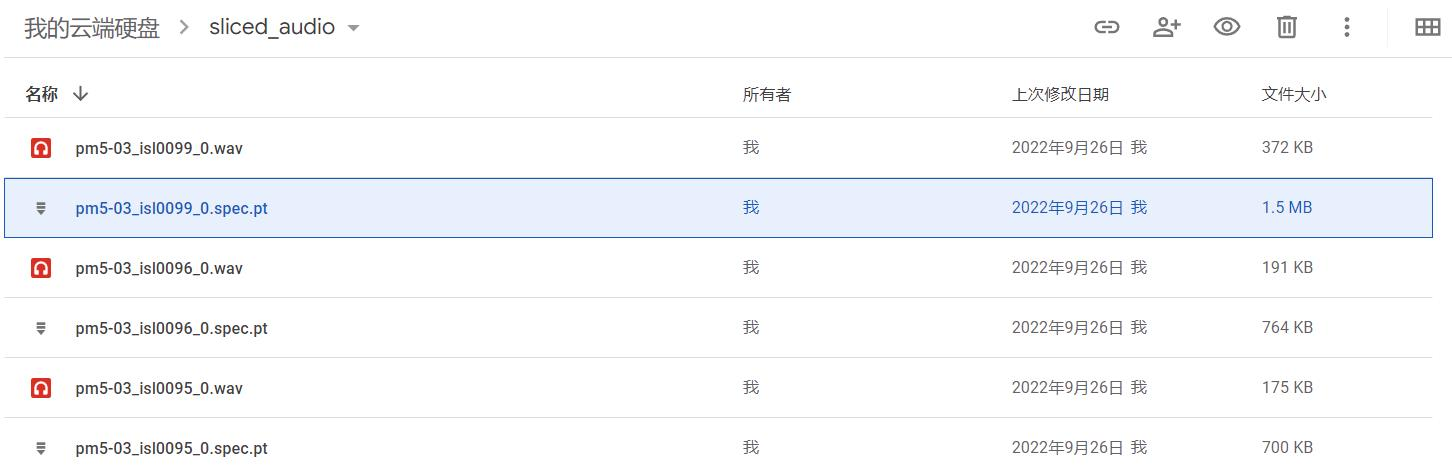

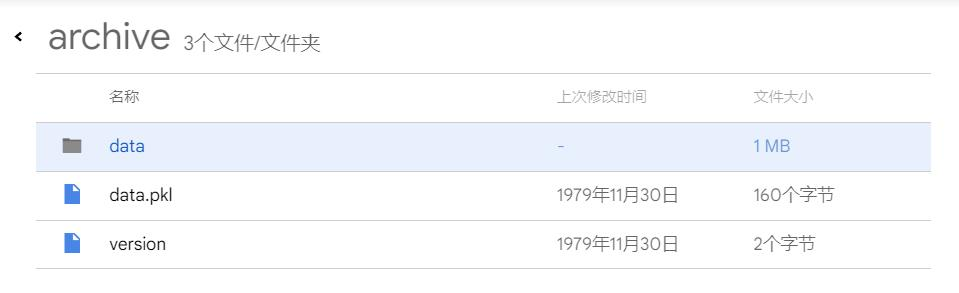

### Restart from Lastest Checkpoint in the Next Time



In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!git clone https://github.com/AlexandaJerry/whisper-vits-japanese

In [ ]:
#把google drive的checkpoint恢复到文件夹
!cp -RT /content/drive/MyDrive/logs/ /content/whisper-vits-japanese/logs/
#把音频文件和对应抄本恢复到文件夹
!cp -RT /content/drive/MyDrive/sliced_audio/ /content/whisper-vits-japanese/sliced_audio/
!cp -RT /content/drive/MyDrive/filelists/ /content/whisper-vits-japanese/filelists/

In [ ]:
%cd /content/whisper-vits-japanese
!pip install -r requirements.txt
!sudo apt-get install espeak -y
%cd monotonic_align
!python setup.py build_ext --inplace
%cd ..

In [ ]:
!python train_ms.py -c configs/Soultide_Collection.json -m Soultide_Collection